# Estimating the energy of a low frequency signal with low-pass filtering

We are interested in computing the energy of a variable $u$ which because it may coexist with higher frequency motions need to be low-pass filtered (filtered variable is denoted $\bar u$).
The energy of the low-frequency signal is then estimated to be:

$
\begin{align}
E &= \big \langle \bar u^2 \big \rangle
\end{align}
$

- Figure: sensitbilité (biais, variance) à la fréquence de coupure du filtre pass-bas vs échelle de temps de décorrelation du signal
- Figure: sensibilité à la quantité de données disponibles
- Figure: sensibilité au sous-sampling (variance préservée)

### references (!to be updated!):

- Bendat and Piersol: *J. S. Bendat and A. G. Piersol. Random Data: Analysis and Measurement Procedures. Wiley series in probability and statistics. Wiley-Interscience, 3rd edition, 2000.*
- Bailey and Hammersley 1946 - general timeseries, sample mean and variance : *G. Bayley and J. Hammersley. The” effective” number of independent observations in an autocorrelated time series. Supplement to the Journal of the Royal Statistical Society, 8(2):184–197, 1946.*
- Zieba 2010: *A. Zieba. Effective number of observations and unbiased estimators of variance for autocorrelated data-an overview. Metrology and Measurement Systems, (1), 2010.*
- Barlett 1946 - long time series, autocorrelations: *M. S. Bartlett. On the theoretical specification and sampling properties of autocorrelated time-series. Supplement to the Journal of the Royal Statistical Society, 8(1):27–41, 1946.*
- Chelton 1983 - multivariate case, cross-correlations: *D. B. Chelton. Effects of sampling errors in statistical estimation. Deep Sea Research Part A. Oceano- graphic Research Papers, 30(10):1083–1103, 1983.*

---
## generate synthetic data

Generate a 100 day time series with an exponential autocorrelation and a 10 days decorrelation timescale

In [6]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp_AP as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=2)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Input parameters:

In [3]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale, base case
dt = 1/24 # hours, sampling interval

# filter properties:
filter_cutoff = [1/10,1/2,0.9] # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

print(f"Default filter cutoff frequency and window size: {filter_cutoff}cpd , {filter_size_pts} points = {filter_size} days ")

Default filter cutoff frequency and window size: [0.1, 0.5, 0.9]cpd , 480 points = 20 days 


In [4]:
# total number of points
#N = ds.time.size # = delta_T/dt 

#effective_DOF(sigma, dt, N)
#print("mean - DOF (Neff):")
#print(f"  exact: {Neff_exact:.1f}")

---
## filter properties

In [7]:
filter_h, filter_t = {},{}
h_hat, w = {},{}
for filt_cut in filter_cutoff:
    filter_h[str(filt_cut)], filter_t[str(filt_cut)] = sigp.lowpass_filter(filt_cut, filter_size_pts, dt)
    h_hat[str(filt_cut)], w[str(filt_cut)] = sigp.filter_response(filter_h[str(filt_cut)], dt)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


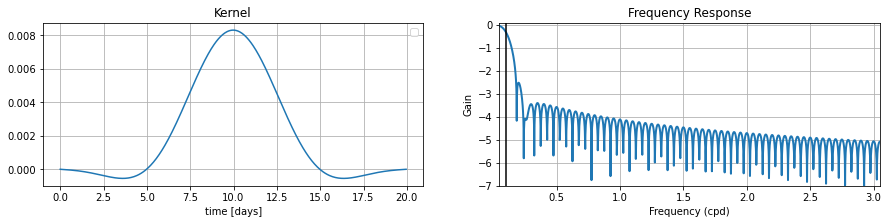

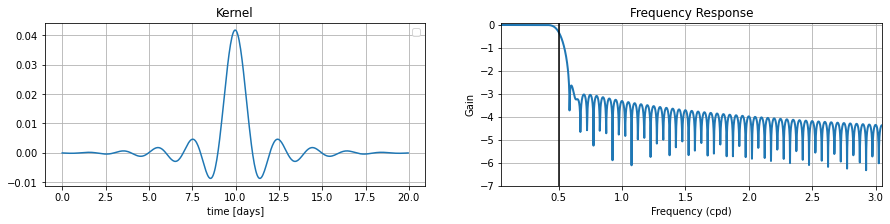

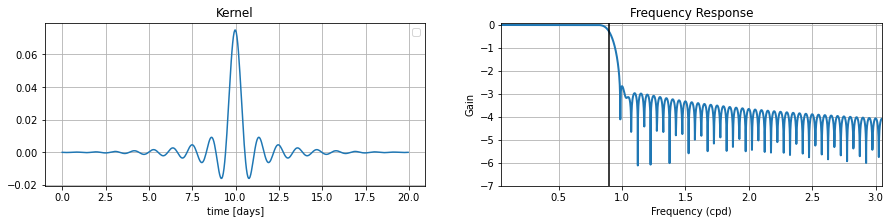

In [8]:
for filt in filter_h.keys():
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    ax = axes[0]
    ax.plot(filter_t[filt], filter_h[filt])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()

    ax = axes[1]
    ax.plot(w[filt], np.log10(abs(h_hat[filt])), linewidth=2)
    ax.axvline(float(filt), color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)

In [9]:
def generate_timeseries(delta_T, n_draws, T, filt, chunks=dict(T=-1)):
    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                             burnin=int(10*T_all[-1]/dt),
                             draws=n_draws,
                             seed=0,
                             chunks=chunks,
                            )
    ds = u.rename("u").to_dataset()
    # low-pass filter
    ds["u_bar"] = sigp.filt(ds.u, filt)    #filter_h
    return ds

---

## filter timer series and look at an overview

In [11]:
delta_T = 300 # time series length in days
n_draws = 500 # number of draws
T_all = [0.1*T, 0.25*T, 0.5*T, T, 2*T]

ds = xr.concat([generate_timeseries(delta_T, n_draws, T_all, filter_h[k]) for k in filter_h.keys()],
               dim='filt').assign_coords({'filt':np.arange(len(filter_cutoff))})
#N = ds.time.size # = delta_T/dt

In [8]:
ds

<xarray.Dataset>
Dimensions:  (T: 5, time: 12000, draw: 100, filt: 3)
Coordinates:
  * T        (T) float64 1.0 2.5 5.0 10.0 20.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * filt     (filt) int64 0 1 2
Data variables:
    u        (filt, T, time, draw) float64 dask.array<chunksize=(1, 5, 12000, 100), meta=np.ndarray>
    u_bar    (filt, T, draw, time) float64 dask.array<chunksize=(1, 5, 100, 12000), meta=np.ndarray>

<xarray.Dataset>
Dimensions:  (T: 5, time: 12000, draw: 100, filt: 3)
Coordinates:
  * T        (T) float64 1.0 2.5 5.0 10.0 20.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * filt     (filt) int64 0 1 2
Data variables:
    u        (filt, T, time, draw) float64 dask.array<chunksize=(1, 5, 12000, 100), meta=np.ndarray>
    u_bar    (filt, T, draw, time) float64 dask.array<chunksize=(1, 5, 100, 12000), meta=np.ndarray>

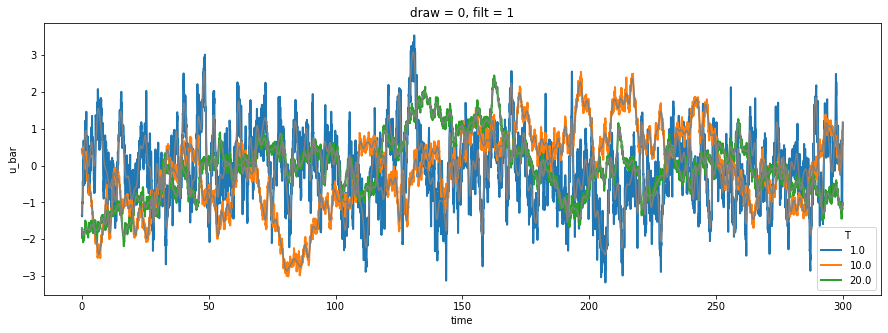

In [12]:
_ds = ds.sel(draw=0, T=[T_all[0], T,  T_all[-1]], filt=1, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ds.u.plot.line(x="time", lw=2)
_ds.u_bar.plot.line(x="time", color="0.5", add_legend=False)

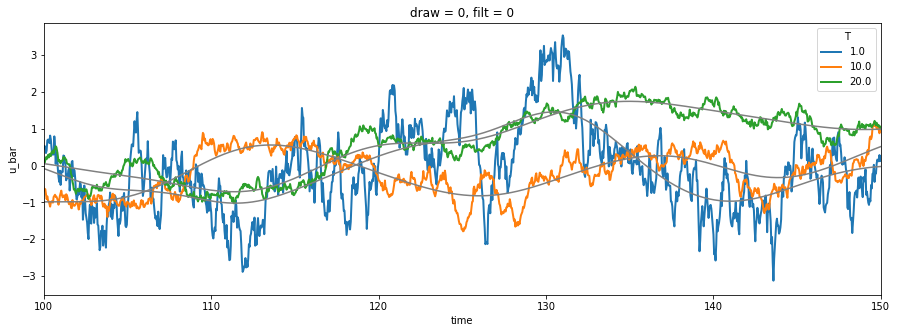

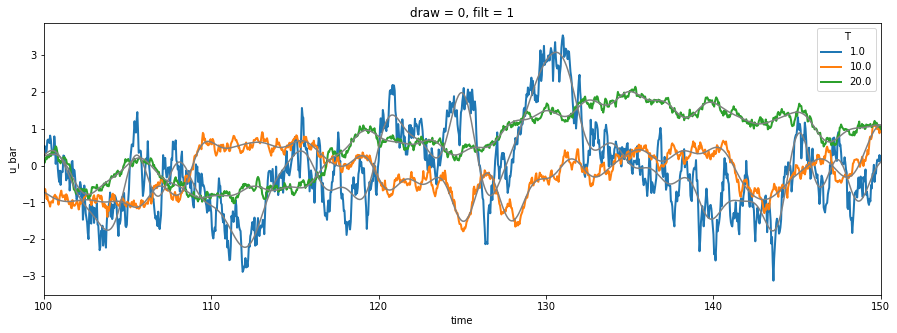

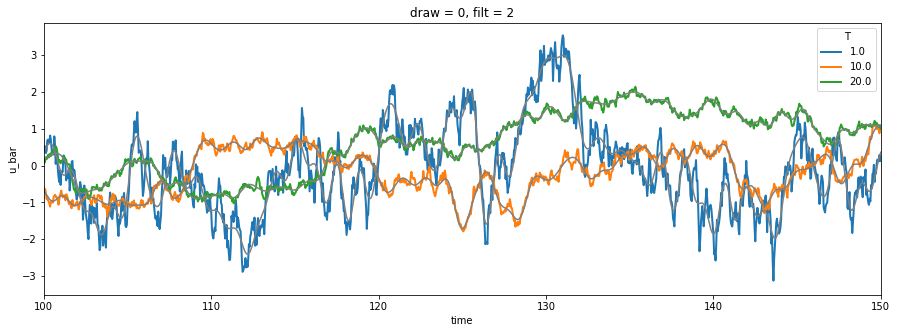

In [13]:
for k in range(len(filter_cutoff)):
    _ds = ds.sel(draw=0, T=[T_all[0], T,  T_all[-1]], method="nearest")
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    _ds.u.sel(filt=k).plot.line(x="time", lw=2)
    _ds.u_bar.sel(filt=k).plot.line(x="time", color="0.5", add_legend=False)
    ax.set_xlim(100,150)

---

## compute the energy (mean square value) of the filtered time series

In [14]:
#n_draws = 1000 # number of draws
#ds = generate_timeseries(delta_T, n_draws, T_all)

E = xr.merge( [(ds.u**2).mean("time"), (ds.u_bar**2).mean("time")]).compute()

(5, 0, 48000)(5, 0, 48000) (480,)
 (480,)
(5, 0, 48000) (480,)

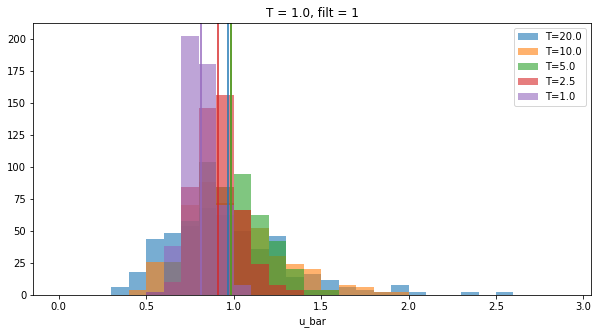

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

bins = np.arange(0,3,.1)
for _T, i in zip(ds.T[::-1],range(len(ds.T))):
    _da = E["u_bar"].sel(T=_T,filt=1)
    _da.plot.hist(bins=bins, alpha=0.6, label=f"T={float(_T)}")
    ax.axvline(_da.mean(), color=f"C{i}")
ax.legend()

Playing with seaborn ...

In [16]:
import seaborn as sns
sns.set_theme(style="whitegrid")

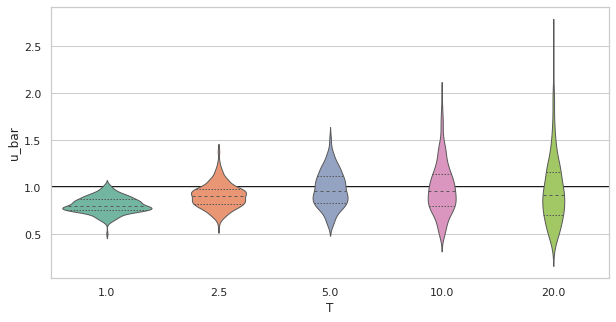

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

df = E["u_bar"].sel(filt=1).to_dataframe().reset_index()
sns.violinplot(data=df, x="T", y="u_bar",
               inner="quart", linewidth=1,
               palette="Set2",
               #palette={"Yes": "b", "No": ".85"})
                #label=f"T={float(_T)}"
               alpha=0.8
              )
ax = ax.axhline(1., lw=2, color="k", zorder=-1)

#sns.despine(left=True)

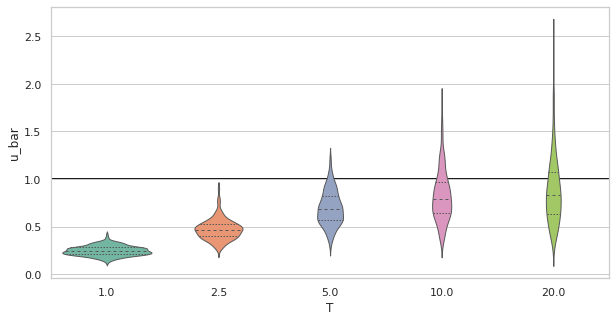

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

df = E["u_bar"].sel(filt=0).to_dataframe().reset_index()
sns.violinplot(data=df, x="T", y="u_bar",
               inner="quart", linewidth=1,
               palette="Set2",
               #palette={"Yes": "b", "No": ".85"})
                #label=f"T={float(_T)}"
               alpha=0.8
              )
ax = ax.axhline(1., lw=2, color="k", zorder=-1)

#sns.despine(left=True)

---

## focus on bias and sensitivity to cutoff/decorrelation timescale ratio

A bit of theory first


In [19]:
from sympy import Symbol, pi, atan, factor, lambdify

In [20]:
u_low = hf.low_frequency_signal()

In [21]:
omegac = Symbol('omega_c', positive=True)
T_sp, U_sp = u_low.p['T'], u_low.p['U']
omega_sp, tau_sp = u_low.omega, u_low.tau

In [22]:
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

In [23]:
I_low = u_low.spectrum.integrate((omega_sp, 0, omegac)) *2  /2/pi
I_low = I_low.simplify()
E_low = lambdify([U_sp, T_sp, omegac], I_low)
I_low

2*U**2*atan(T*omega_c)/pi

Compare observed mean with theoretical prediction

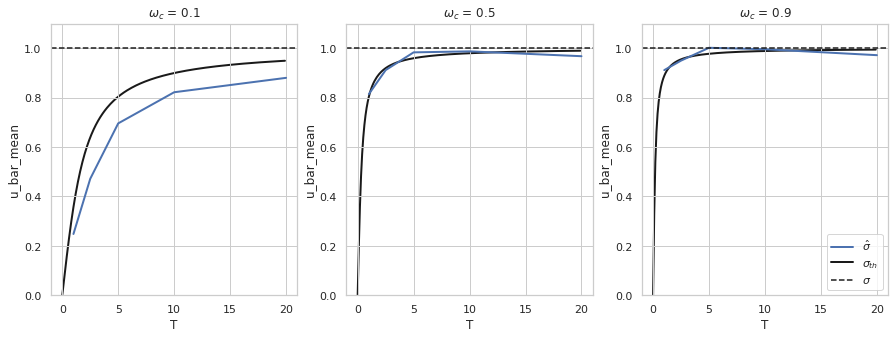

In [24]:
E["u_bar_mean"] = E.u_bar.mean("draw")


fig, axs = plt.subplots(1,len(filter_h.keys()), figsize=(5*len(filter_h.keys()),5))

for i,k in enumerate(filter_h.keys()):
#ds.E_ubar_theoretical.plot()
    E["u_bar_theoretical"] = E_low(np.sqrt(sigma0), ds.T, filter_cutoff[i]*2*np.pi)
    E.u_bar_mean.sel(filt=i).plot(lw=2,ax=axs[i],label=r'$\hat{\sigma}$')
#ds.E_ubar_mean.plot.bar()

    # more finely resolved theoretical curve
    _T = np.arange(0, float(ds.T.max()),.1)
    _E = E_low(np.sqrt(sigma0), _T, filter_cutoff[i]*2*np.pi)
    axs[i].plot(_T,_E, lw=2, color="k", zorder=-1,label=r'$\sigma_{th}$')
    axs[i].axhline(np.sqrt(sigma0),linestyle='--', c='k',label=r'$\sigma$')
    axs[i].set_title(r'$\omega_c$ = %s'%k)
    axs[i].set_ylim(0., 1.1)
axs[-1].legend()
    

---

## focus on variance and confidence intervals

Assuming the time series are normally distributed, the energy will follow a chi square distribution (potentially non-centered):

$
\begin{align}
\frac{N x \hat E}{E}  = \chi^2(N, N \mu^2/\sigma^2)
\end{align}
$

where $N$ is the effective degrees of freedom for the variance.
So the pdf of the energy $E$ is :

$
\begin{align}
p_E(x) = \frac{N}{E} p_\chi(x\times N/E),
\end{align}
$

and the following confidence interval can be employed:

$
\begin{align}
%q_{\alpha/2} < \frac{N x \hat E}{E}  = \chi^2(N, N \mu^2/\sigma^2), \\
\hat E \times \frac{N}{q_{1-\alpha/2}} < E < \hat E \times \frac{N}{q_{\alpha/2}},
\end{align}
$

where $q_\alpha$ is the $\alpha$ percentile of the $\chi^2$ distribution.

https://fr.wikipedia.org/wiki/Loi_du_%CF%87%C2%B2_non_centr%C3%A9e
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ncx2.html

for different number of points and one timescale.

regenerate dataset

In [28]:
ds = ds.sel(filt=1)
E = E.sel(filt=1)
E_pdf_expected = lambda x, Ne, sigma0: Ne/sigma0*stats.ncx2.pdf(x*Ne/sigma0, Ne-1, Ne*mu**2/sigma0)

# compute effective degrees of freedom
N = ds.u.time.size
def compute_Ne(T):
    L = []
    for t in T:
        c = lambda tau, t=t: sigma0*np.exp(-np.abs(tau/t))
        L.append(list(sigp.effective_DOF(c, dt, N)))
    Ne_mean, Ne_variance, _ = zip(*L)
    return list(Ne_mean), list(Ne_variance)

_N = compute_Ne(E.T.values)

E["Ne_mean"] = ("T", _N[0])
E["Ne_variance"] = ("T", _N[1])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


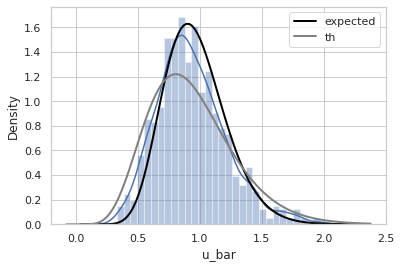

In [26]:
_E = E.sel(T=10.)

ax = sns.distplot(_E.u_bar, bins=30, norm_hist=True)

def add_dist(Ne, label, color):
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), sigma0)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)                                                     

add_dist(_E.Ne_variance, "expected", "black")
add_dist(_E.Ne_mean, "th", "0.5")

ax.legend()
#ax.set_ylim(0, 1.)

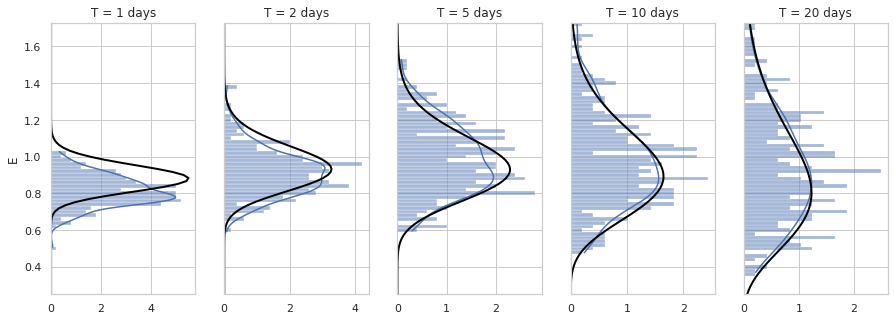

In [29]:
def add_dist(Ne, sigma0, label, color, ax):
    x0, x1 = ax.get_ylim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), float(sigma0))
    ax.plot(y_pdf, x_pdf, color=color, lw=2, label=label)
    #ax.plot(x-y_pdf, x_pdf, color=color, lw=2, label=label)

bins = np.arange(.25, 1.75, .02)

fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

for _T, ax in zip(E.T, axes):
    _E = E.sel(T=_T)
    ax = sns.histplot(y=_E.u_bar, stat="density", bins=bins, kde=True, ax=ax)
    add_dist(_E.Ne_variance, _E.u_bar_theoretical, "expected", "black", ax)
    ax.set_title(f"T = {float(_T):.0f} days")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim(bins[0], bins[-1])
    if ax!=axes[0]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("E")

In [29]:
#stats.chi2.ppf(1-alpha/2, Ne-1)

In [30]:
alpha=0.1

#_Ne = E["Ne_mean"] # leads to an overestimate of the CI
_Ne = E["Ne_variance"] # about right
E["u_bar_low_delta"] =  _Ne/stats.ncx2.ppf(1-alpha/2, _Ne, _Ne*mu**2/E["u_bar_theoretical"])
E["u_bar_high_delta"] = _Ne /stats.ncx2.ppf(alpha/2, _Ne, _Ne*mu**2/E["u_bar_theoretical"])

Text(0.5, 1.0, 'CI hit rate')

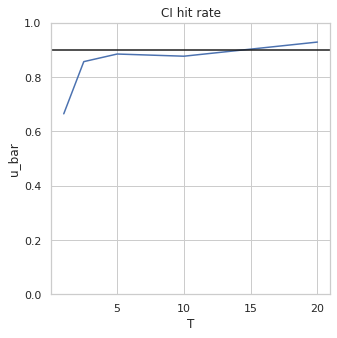

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

dum = E.u_bar.where( (E.u_bar * E.u_bar_low_delta < E.u_bar_theoretical) 
                    & (E.u_bar * E.u_bar_high_delta > E.u_bar_theoretical) 
                   )*0+1
dum = dum.fillna(0.).mean("draw")
dum.plot()
ax.axhline(1-alpha, color="k")
ax.set_ylim(0,1)
ax.set_title("CI hit rate") # i.e. number of times the true value is within the CI

---

## sensibility to subsampling

For one decorrelation timescale (10 days) and fixed data quantity (200 days), data is decimated temporally.
Statistical variablity of the energy estimate is quantified and monitored as subsampling interval is increased.


In [32]:
delta_T = 200 # time series length in days
n_draws = 10000 # number of draws
ds = generate_timeseries(delta_T, n_draws, T,filter_h['0.5']).persist()

In [33]:
delta = [1,6,12,24,30,24*2,24*4,24*10,24*20,24*30,24*40]
delta_days = np.array(delta)*dt
filter_cutoff =filter_cutoff[1]
c = lambda tau: sigma0*np.exp(-np.abs(tau/T))

def get_E(ds):
    E = xr.merge( [(ds.u**2).mean("time"), (ds.u_bar**2).mean("time")])

    dt = float(ds.time[1] - ds.time[0])
    N = ds.time.size
    Ne_mean, Ne_variance, _ = sigp.effective_DOF(c, dt, N)
    
    E["Ne_mean"]  = Ne_mean
    E["Ne_variance"]  = Ne_variance

    return E

E = xr.concat([get_E(ds.isel(time=slice(0,None,d))) for d in delta], "delta")
E = E.assign_coords(delta=delta_days).compute()

E["u_bar_theoretical"] = E_low(np.sqrt(sigma0), T, filter_cutoff*2*np.pi)
E["u_bar_low"] =  (E["u_bar_theoretical"]/E.Ne_variance 
                   *stats.ncx2.ppf(alpha/2, E.Ne_variance, E.Ne_variance*mu**2/E["u_bar_theoretical"])
                  )
E["u_bar_high"] =  (E["u_bar_theoretical"]/E.Ne_variance
                   *stats.ncx2.ppf(1-alpha/2, E.Ne_variance, E.Ne_variance*mu**2/E["u_bar_theoretical"])
                   )

#E

Text(0, 0.5, 'energy')

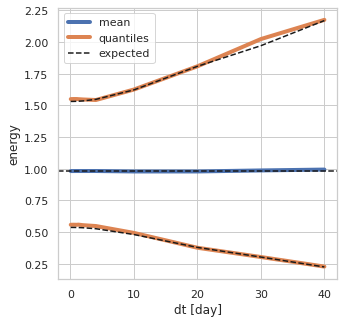

In [34]:
Eq = E.u_bar.quantile([alpha/2,1-alpha/2],"draw")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

E.u_bar.mean("draw").plot(lw=4, label="mean")
Eq.isel(quantile=0).plot.line(x="delta", color="C1", lw=4, add_legend=False, label=f"quantiles")
Eq.isel(quantile=1).plot.line(x="delta", color="C1", lw=4, add_legend=False, label=None)

ax.axhline(E.u_bar_theoretical, color="k", ls="--", label="expected")
E.u_bar_low.plot(color="k", ls="--")
E.u_bar_high.plot(color="k", ls="--")

ax.legend()
ax.set_title("")
ax.set_xlabel("dt [day]")
ax.set_ylabel("energy")

For sampling interval less than a 1/10 of the decorrelation length scale, there is no substantial increase of statistical variability

---
## expected interval in quantiles in (time interval , time step) space

In [35]:
ds = xr.Dataset(dict(alpha=np.geomspace(1e-2, 1e2, num=100), # time sampling: dt/T
                     beta=np.geomspace(2, 1e3, num=100)), # Time interval: delta_T / T
               )

ds["dt"] = T*ds.alpha
ds["N"] = (T*ds.beta/ds.dt).astype(int)

In [36]:
c = lambda tau: sigma0*np.exp(-np.abs(tau/T))

def compute_Ne(dt, N, estimate="variance"):
    if np.isnan(N):
        return np.NaN
    Ne_mean, Ne_variance, _ = sigp.effective_DOF(c, dt, N)
    if estimate=="variance":
        return Ne_variance
    elif estimate=="mean":
        return Ne_mean
    
ds["Ne"] = xr.apply_ufunc(compute_Ne, ds.dt, ds.N, vectorize=True)

ds["low"] = 1/ds.Ne*stats.ncx2.ppf(alpha/2, ds.Ne, ds.Ne*mu**2/1)
ds["high"] = 1/ds.Ne*stats.ncx2.ppf(1-alpha/2, ds.Ne, ds.Ne*mu**2/1)    

/home1/datahome/zcaspar/synthetic_stats/sstats/sigp_AP.py:215: RuntimeWarning: divide by zero encountered in true_divide
  mean_Ne = N / np.sum( ( 1-np.abs(lags)/N )*sigma(lags*dt) )
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp_AP.py:220: RuntimeWarning: divide by zero encountered in true_divide
  variance_Ne = N / np.sum( ( 1-np.abs(lags)/N ) * sigma(lags*dt)**2 )
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp_AP.py:222: RuntimeWarning: invalid value encountered in double_scalars
  variance_scale = mean_Ne * (N-1) /N /(mean_Ne-1)


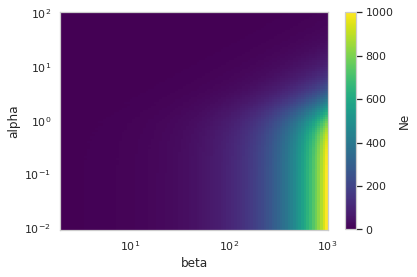

In [37]:
fig, ax = plt.subplots(1,1)
ds["Ne"].plot()
ax.set_xscale("log")
ax.set_yscale("log")

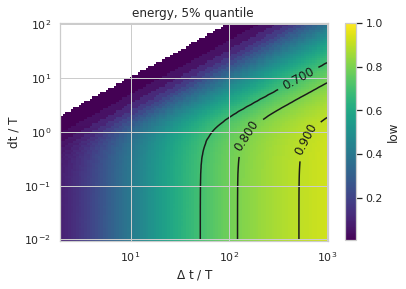

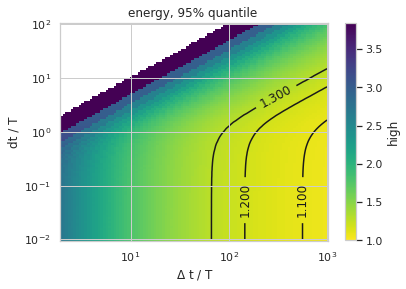

In [38]:
def plot_stat(da, levels, title, **kwargs):

    fig, ax = plt.subplots(1,1)
    da.plot(zorder=-1, **kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")

    CS = da.plot.contour(levels=levels, colors="k", zorder=-1)
    ax.clabel(CS, inline=True)
    ax.set_xlabel(r"$\Delta$ t / T")
    ax.set_ylabel("dt / T")

    ax.grid()
    ax.set_title(title)
    
plot_stat(ds["low"], [0.7, 0.8, 0.9], f"energy, {alpha/2*100:.0f}% quantile ", vmax=1)
plot_stat(ds["high"], [1.1, 1.2, 1.3], f"energy, {(1-alpha/2)*100:.0f}% quantile ", vmin=1, cmap="viridis_r")

In [39]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
